Importing the required libraries:

In [1]:
import numpy as np
import pandas as pd
from math import sqrt

import pickle
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## for machine learning

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error

from tensorflow import keras

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Masking

## Preparing the sine wave function

In [2]:
x_axis = np.arange(-50*np.pi, 50*np.pi, 0.1)
y_1_axis = np.sin(x_axis)
y_2_axis = np.sin(2*x_axis)
y_3_axis = np.sin(3*x_axis)
y_axis = y_1_axis + y_2_axis + y_3_axis

df = pd.DataFrame({"x_axis": x_axis, "y_axis":y_axis})

df.head()

,x_axis,y_axis
0,-157.079633,2.252855e-14
1,-156.979633,5.940230e-01
2,-156.879633,1.152730e+00
3,-156.779633,1.643490e+00
4,-156.679633,2.038814e+00


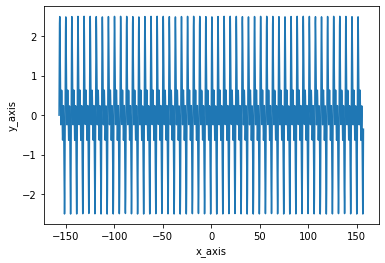

In [3]:
sns.lineplot(data=df, x="x_axis", y="y_axis");

In [4]:
# Adding NaN values to the dataframe
import random
col = 1

for row in random.sample(range(len(df)), int(round(.1*len(df)))):
    df.iat[row, col] = np.nan


df.head(10)

,x_axis,y_axis
0,-157.079633,2.252855e-14
1,-156.979633,NaN
2,-156.879633,1.152730e+00
3,-156.779633,1.643490e+00
4,-156.679633,2.038814e+00
5,-156.579633,2.318392e+00
6,-156.479633,2.470529e+00
7,-156.379633,2.492877e+00
8,-156.279633,2.392393e+00
9,-156.179633,2.184554e+00


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x_axis  3142 non-null   float64
 1   y_axis  2828 non-null   float64
dtypes: float64(2)
memory usage: 49.2 KB


In [6]:
df_eq_model = df.copy()

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(2827, 2) (315, 2)


In [7]:
train.head(2)

,x_axis,y_axis
0,-157.079633,2.252855e-14
1,-156.979633,NaN


In [8]:
test.head(2)

,x_axis,y_axis
2827,125.620367,-0.259545
2828,125.720367,0.338877


In [9]:
from sklearn.preprocessing import RobustScaler

f_columns = ["x_axis"]

f_transformer = RobustScaler()
y_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
y_transformer = y_transformer.fit(train[["y_axis"]])

In [10]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [11]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["y_axis"] = y_transformer.transform(train[["y_axis"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["y_axis"] = y_transformer.transform(test[["y_axis"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Preparing the data for LSTM

In [12]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [13]:
TIME_STEPS = 60

X_train, y_train = create_dataset(train, train["y_axis"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["y_axis"], time_steps= TIME_STEPS)

In [14]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(2767, 60, 2) (2767,)
(255, 60, 2) (255,)


In [15]:
X_train[0][0]

array([-1.        , -0.01067265])

## Model Architecture

In [16]:

model = keras.Sequential()
# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [17]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [18]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/20
58/58 [==============================] - 2s 30ms/step - loss: nan - val_loss: nan
Epoch 2/20
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 3/20
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 4/20
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 5/20
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 6/20
58/58 [==============================] - 1s 19ms/step - loss: nan - val_loss: nan
Epoch 7/20
58/58 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 8/20
58/58 [==============================] - 1s 18ms/step - loss: nan - val_loss: nan
Epoch 9/20
58/58 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 10/20
58/58 [==============================] - 1s 17ms/step - loss: nan - val_loss: nan
Epoch 11/20
58/58 [==============================] - 1s 17ms/step - l

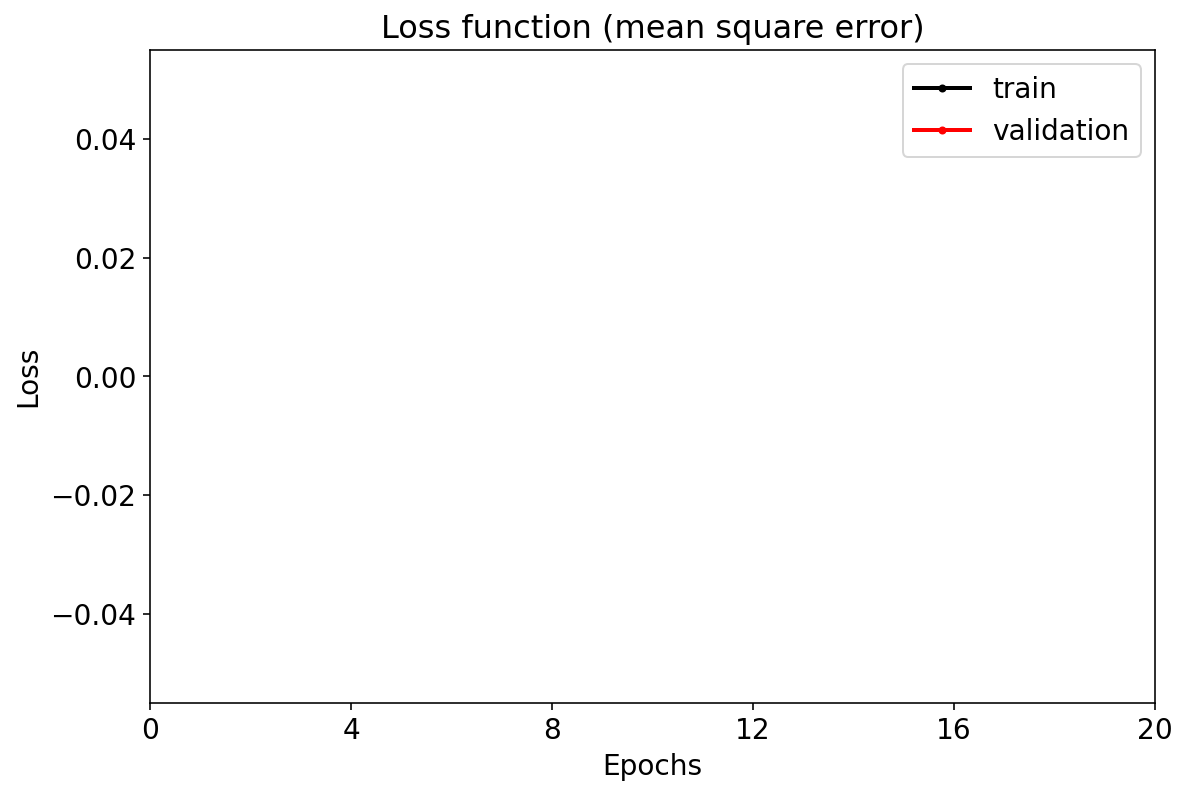

In [19]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(history.history["loss"], color='black', marker = '.', linewidth = 2, label = "train")
plt.plot(history.history["val_loss"], color='red', marker = '.', linewidth = 2, label = "validation")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(np.arange(0, 20+1, 4))
plt.xlim(0, 20)
# plt.ylim(0, 3)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)

plt.title("Loss function (mean square error)", fontsize = 16);
plt.savefig('../plots/fig_1_medium_a.png')

In [20]:
y_pred = model.predict(X_test)

In [21]:
y_train_inv = y_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = y_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = y_transformer.inverse_transform(y_pred)

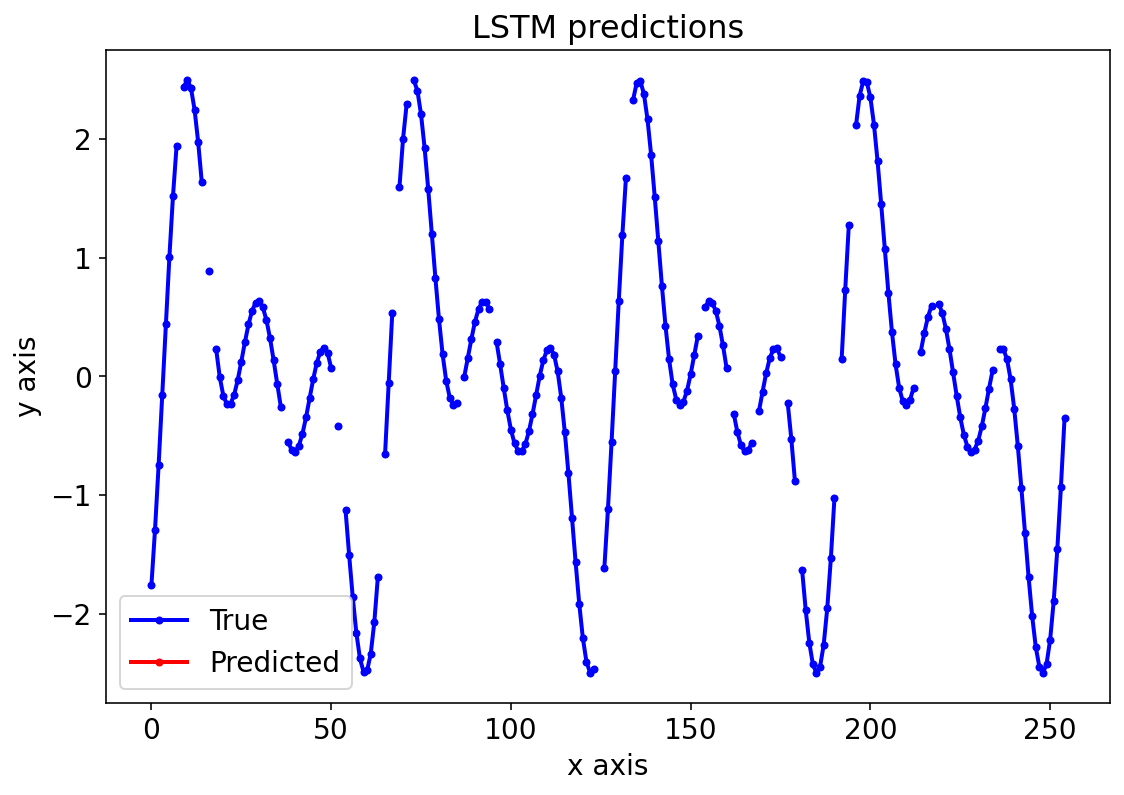

In [22]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), color='blue', marker = '.', linewidth = 2, label = "True")
plt.plot(y_pred_inv.flatten(), color='red', marker = '.', linewidth = 2, label = "Predicted")

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.xlim(0, 250)
# plt.ylim(0, 3)
plt.xlabel("x axis", fontsize = 14)
plt.ylabel("y axis", fontsize = 14);
plt.title("LSTM predictions", fontsize = 16);


plt.savefig('../plots/fig_1_medium_b.png')

# Refining the model by adding mask

## Model Architecture

In [23]:
## Filling NA with -1
df.fillna(-1.0, inplace=True)

df.describe().T

,count,mean,std,min,25%,50%,75%,max
x_axis,3142.0,-0.029633,90.716160,-157.079633,-78.554633,-0.029633,78.495367,157.020367
y_axis,3142.0,-0.089677,1.202761,-2.499602,-1.000000,-0.104075,0.500970,2.499608


In [24]:
df_eq_model = df.copy()

train_size = int(len(df_eq_model)* 0.9)
test_size = len(df_eq_model) - train_size
train, test = df_eq_model.iloc[0:train_size], df_eq_model.iloc[train_size:len(df_eq_model)]

print(train.shape, test.shape)

(2827, 2) (315, 2)


In [25]:
train.head(5)

,x_axis,y_axis
0,-157.079633,2.252855e-14
1,-156.979633,-1.000000e+00
2,-156.879633,1.152730e+00
3,-156.779633,1.643490e+00
4,-156.679633,2.038814e+00


In [26]:
test.head(5)

,x_axis,y_axis
2827,125.620367,-0.259545
2828,125.720367,0.338877
2829,125.820367,0.917114
2830,125.920367,1.441050
2831,126.020367,1.880690


In [27]:
from sklearn.preprocessing import RobustScaler

f_columns = ["x_axis"]

f_transformer = RobustScaler()
y_transformer = RobustScaler()

f_transformer = f_transformer.fit(train[f_columns].to_numpy())
y_transformer = y_transformer.fit(train[["y_axis"]])

In [28]:
f_transformer.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'with_centering': True,
 'with_scaling': True}

In [29]:
train.loc[:,f_columns] = f_transformer.transform(train[f_columns].to_numpy())
train["y_axis"] = y_transformer.transform(train[["y_axis"]])

test.loc[:,f_columns] = f_transformer.transform(test[f_columns].to_numpy())
test["y_axis"] = y_transformer.transform(test[["y_axis"]])

/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/smighani/opt/anaconda3/envs/dsi/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

### Preparing the data for LSTM

In [30]:
def create_dataset(X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)- time_steps):
        v = X.iloc[i: (i + time_steps)].to_numpy()
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
    return np.array(Xs), np.array(ys)


In [31]:
TIME_STEPS = 30

X_train, y_train = create_dataset(train, train["y_axis"], time_steps = TIME_STEPS)

X_test, y_test = create_dataset(test, test["y_axis"], time_steps= TIME_STEPS)

In [32]:
print(X_train.shape, y_train.shape)

print(X_test.shape, y_test.shape)



(2797, 30, 2) (2797,)
(285, 30, 2) (285,)


In [33]:
X_train[0][0]

array([-1.        ,  0.06887561])

In [34]:

model = keras.Sequential()
# Adding mask layer for NaN values
model.add(Masking(mask_value = -1.0,
                                  input_shape=(X_train.shape[1], X_train.shape[2])
                              )
         )
# Adding mask layer for NaN values


# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [35]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [36]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/20
59/59 [==============================] - 2s 41ms/step - loss: 0.3673 - val_loss: 0.2051
Epoch 2/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1718 - val_loss: 0.1421
Epoch 3/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1561 - val_loss: 0.1204
Epoch 4/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1377 - val_loss: 0.1099
Epoch 5/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1281 - val_loss: 0.1051
Epoch 6/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1250 - val_loss: 0.1029
Epoch 7/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1194 - val_loss: 0.1044
Epoch 8/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1182 - val_loss: 0.1066
Epoch 9/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1198 - val_loss: 0.1013
Epoch 10/20
59/59 [==============================] - 1s 14ms/step - loss: 0.1150 - val_loss: 0.1019
Epoch 11/

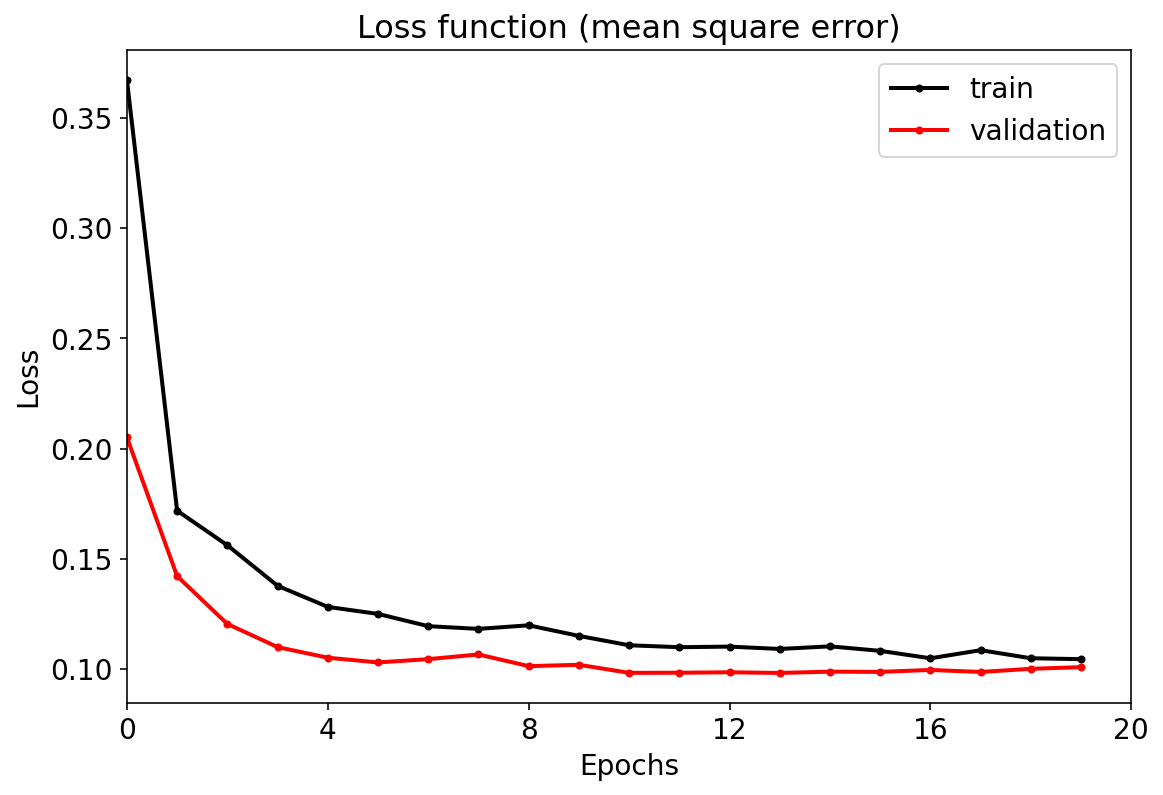

In [37]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(history.history["loss"], color='black', marker = '.', linewidth = 2, label = "train")
plt.plot(history.history["val_loss"], color='red', marker = '.', linewidth = 2, label = "validation")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(np.arange(0, 20+1, 4))
plt.xlim(0, 20)
# plt.ylim(0, 3)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)

plt.title("Loss function (mean square error)", fontsize = 16);
plt.savefig('../plots/fig_1_medium_a.png')

In [38]:
y_pred = model.predict(X_test)

In [39]:
y_train_inv = y_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = y_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = y_transformer.inverse_transform(y_pred)

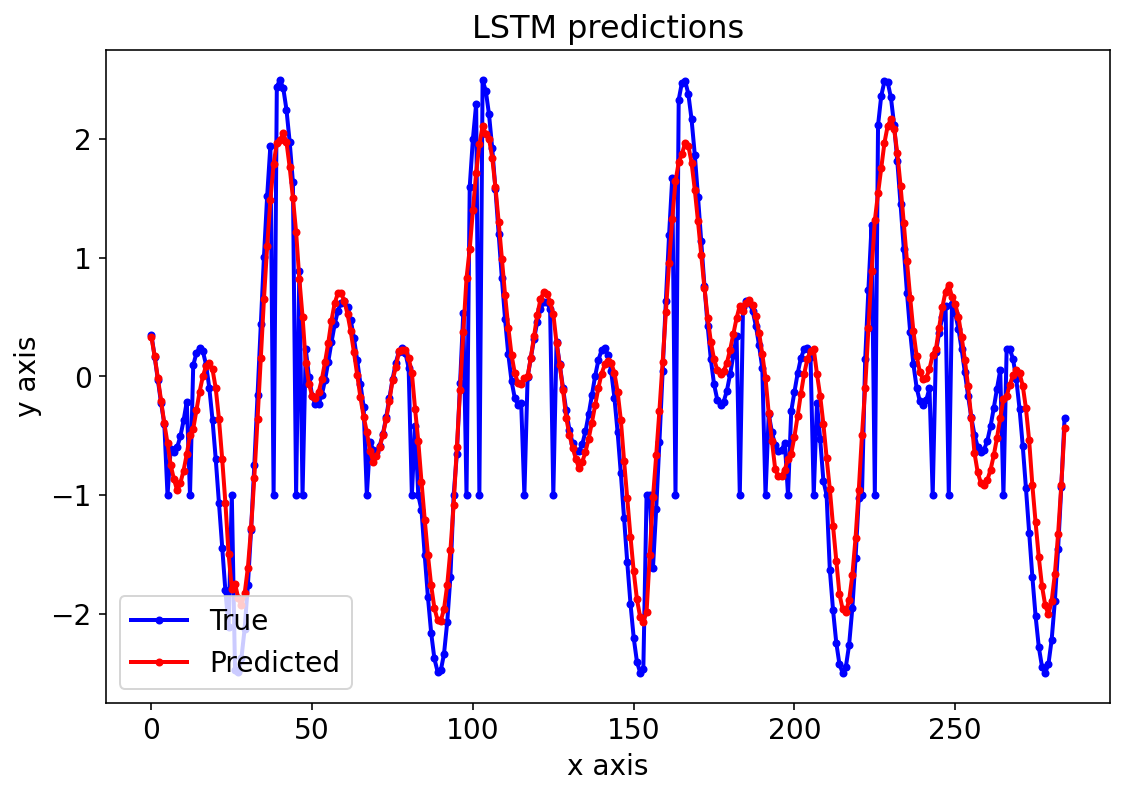

In [40]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), color='blue', marker = '.', linewidth = 2, label = "True")
plt.plot(y_pred_inv.flatten(), color='red', marker = '.', linewidth = 2, label = "Predicted")

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.xlim(0, 250)
# plt.ylim(0, 3)
plt.xlabel("x axis", fontsize = 14)
plt.ylabel("y axis", fontsize = 14);
plt.title("LSTM predictions", fontsize = 16);


plt.savefig('../plots/fig_1_medium_b.png')

## What happens if I didnt add the mask layer for LSTM architecture ?

In [41]:

model = keras.Sequential()

# Adding bi-directional layer
model.add(
    keras.layers.Bidirectional(
        keras.layers.LSTM(
            units=64,
            input_shape = (X_train.shape[1], X_train.shape[2])
        )
    )
)
# Adding dropout layer to regularize complexities 
model.add(keras.layers.Dropout(rate = 0.2))
# Add output layer
model.add(keras.layers.Dense(units = 1))


In [42]:
# Compiling the model
model.compile(loss = "mean_squared_error", optimizer = "adam")

In [43]:
history = model.fit(
    X_train, y_train,
    epochs = 20,
    batch_size = 32,
    validation_split = 0.33, 
    shuffle = False # As it is time-series
)

Epoch 1/20
59/59 [==============================] - 1s 23ms/step - loss: 0.4462 - val_loss: 0.2264
Epoch 2/20
59/59 [==============================] - 1s 9ms/step - loss: 0.1654 - val_loss: 0.1468
Epoch 3/20
59/59 [==============================] - 1s 9ms/step - loss: 0.1456 - val_loss: 0.1395
Epoch 4/20
59/59 [==============================] - 1s 9ms/step - loss: 0.1332 - val_loss: 0.1147
Epoch 5/20
59/59 [==============================] - 1s 12ms/step - loss: 0.1240 - val_loss: 0.1127
Epoch 6/20
59/59 [==============================] - 1s 12ms/step - loss: 0.1206 - val_loss: 0.1185
Epoch 7/20
59/59 [==============================] - 1s 13ms/step - loss: 0.1204 - val_loss: 0.1055
Epoch 8/20
59/59 [==============================] - 1s 12ms/step - loss: 0.1152 - val_loss: 0.1034
Epoch 9/20
59/59 [==============================] - 1s 12ms/step - loss: 0.1147 - val_loss: 0.1029
Epoch 10/20
59/59 [==============================] - 1s 12ms/step - loss: 0.1142 - val_loss: 0.1001
Epoch 11/20


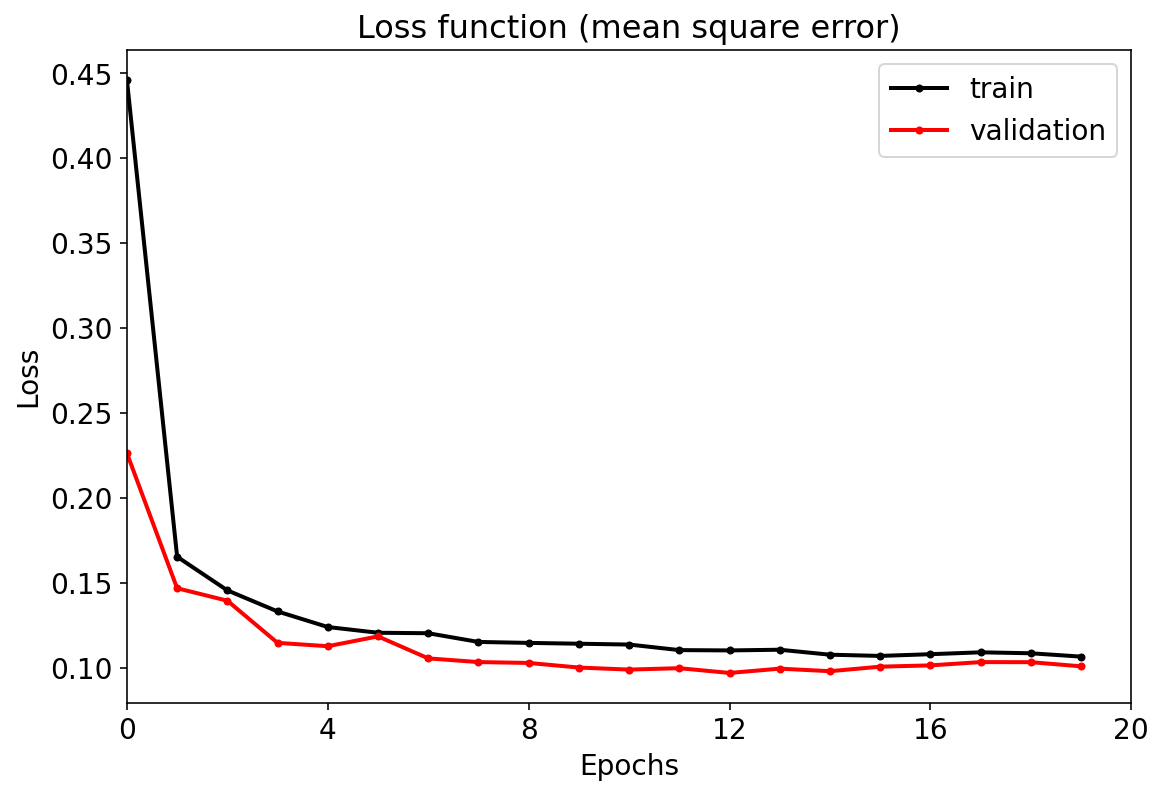

In [44]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(history.history["loss"], color='black', marker = '.', linewidth = 2, label = "train")
plt.plot(history.history["val_loss"], color='red', marker = '.', linewidth = 2, label = "validation")
plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(np.arange(0, 20+1, 4))
plt.xlim(0, 20)
# plt.ylim(0, 3)
plt.xlabel("Epochs", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)

plt.title("Loss function (mean square error)", fontsize = 16);
plt.savefig('../plots/fig_1_medium_a.png')

In [45]:
y_pred = model.predict(X_test)

In [46]:
y_train_inv = y_transformer.inverse_transform(y_train.reshape(1,-1))
y_test_inv = y_transformer.inverse_transform(y_test.reshape(1,-1))
y_pred_inv = y_transformer.inverse_transform(y_pred)

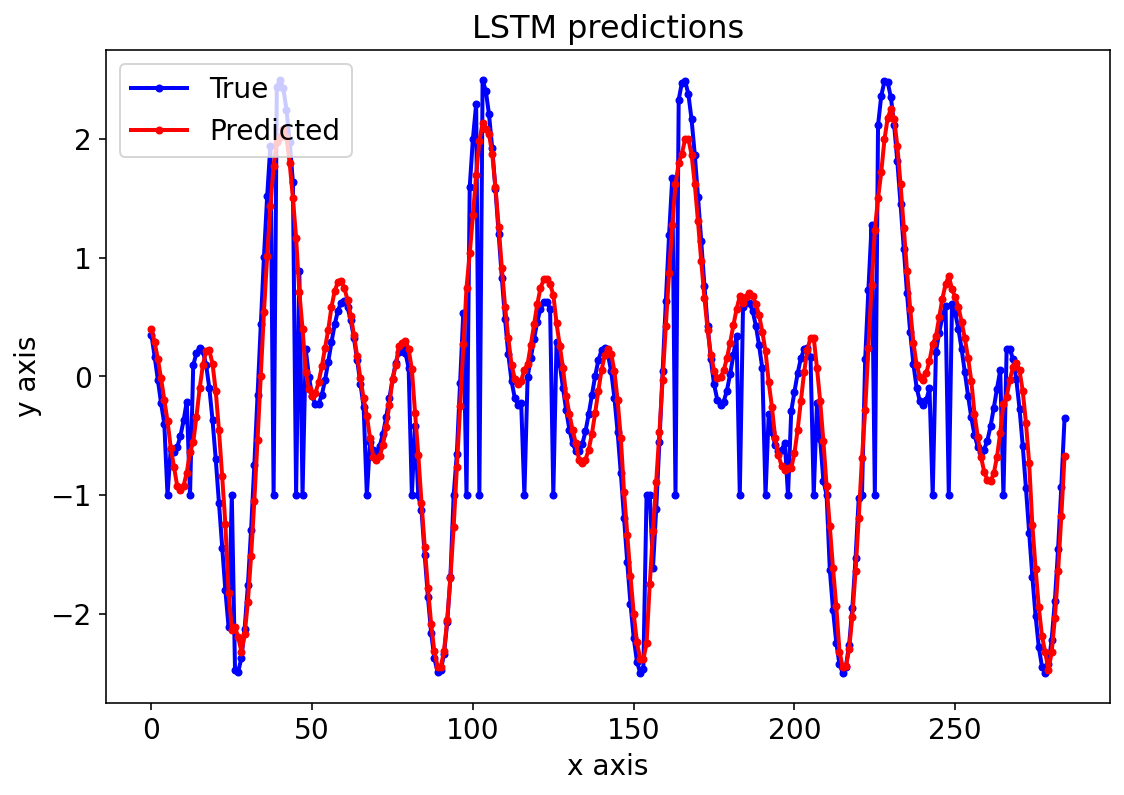

In [47]:
%config InlineBackend.figure_format = 'retina'


plt.figure(figsize = (9, 6))


# plt.figure(figsize = (14,10))
plt.plot(y_test_inv.flatten(), color='blue', marker = '.', linewidth = 2, label = "True")
plt.plot(y_pred_inv.flatten(), color='red', marker = '.', linewidth = 2, label = "Predicted")

plt.legend(fontsize = 14)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.xlim(0, 250)
# plt.ylim(0, 3)
plt.xlabel("x axis", fontsize = 14)
plt.ylabel("y axis", fontsize = 14);
plt.title("LSTM predictions", fontsize = 16);


plt.savefig('../plots/fig_1_medium_b.png')

In [48]:
print("Hello World!")

Hello World!
